# Reconstruct HRTF using PCA, learn PCs using DNN

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from utils_data import load_hutubs_1_ears
from utils_model_1d import create_dnn_concat
from utils_train import train_model_dnn_concat
from utils_plot import plot_reconstructions_chen2019, plot_xcorr, plot_latent_space

## Dataset settings

In [4]:
## show all possible setups
dataset_configs = sio.loadmat('./data/hutubs_hrtf/configs.mat')
azimuths = dataset_configs['azimuths'][0]
elevations = dataset_configs['elevations'][0]
freqs = dataset_configs['f'][0]
viable_ids = [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
    17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
    51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
    68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84,
    85, 86, 87, 89, 90, 91, 93, 94, 95]
viable_ids_img = [ 10, 11, 12, 16, 19, 20, 21, 22, 23, 29, 2, 30, 31, 
    32, 33, 3, 40, 41, 44, 45, 46, 47, 48, 49, 4, 55, 57, 
    58, 59, 5, 60, 61, 62, 63, 66, 67, 68, 69, 6, 70, 71, 
    72, 73, 76, 77, 78, 80, 81, 82, 89, 8, 90, 91, 95, 9]
print('- All azimuths: ', azimuths) 
print('- All elevations: ', elevations)
print('- All viable IDs: ', viable_ids)
print('- All viable IDs with depthmaps: ', viable_ids_img)

- All azimuths:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355]
- All elevations:  [-85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0
   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90]
- All viable IDs:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95]
- All viable IDs with depthmaps:  [10, 11, 12, 16, 19, 20, 21, 22, 23, 29, 2, 30, 31, 32, 33, 3, 40, 41, 44, 45, 46, 47, 48, 49, 4, 55, 57, 58, 59, 5, 6

In [67]:
## SETTINGS 
# experiment settings
ids = np.array(viable_ids_img)
filters = {
    'ids': ids,
    'ears': ['left'],
    'azimuths': (np.arange(-45,46,5) % 360),
    'elevations': np.arange(-45,46,5)
}
n_splits = 10
n_pc = 20
f_range = (300, 16000)

# model settings
filters_layers = [128, 64, 32]
batch_size = 512
epochs = 300
print('- Choosen IDs: ', ids)
print('- Filters: ', filters)

- Choosen IDs:  [10 11 12 16 19 20 21 22 23 29  2 30 31 32 33  3 40 41 44 45 46 47 48 49
  4 55 57 58 59  5 60 61 62 63 66 67 68 69  6 70 71 72 73 76 77 78 80 81
 82 89  8 90 91 95  9]
- Filters:  {'ids': array([10, 11, 12, 16, 19, 20, 21, 22, 23, 29,  2, 30, 31, 32, 33,  3, 40,
       41, 44, 45, 46, 47, 48, 49,  4, 55, 57, 58, 59,  5, 60, 61, 62, 63,
       66, 67, 68, 69,  6, 70, 71, 72, 73, 76, 77, 78, 80, 81, 82, 89,  8,
       90, 91, 95,  9]), 'ears': ['left'], 'azimuths': array([315, 320, 325, 330, 335, 340, 345, 350, 355,   0,   5,  10,  15,
        20,  25,  30,  35,  40,  45]), 'elevations': array([-45, -40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,
        20,  25,  30,  35,  40,  45])}


In [68]:
# calculate spectral distortion on given freq range
def spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range):
    fmin, fmax = f_range
    # get bins in range
    f_idx = []
    for i,f in enumerate(freqs):
        if f > fmin and f < fmax:
            f_idx.append(i)
    # formula: sqrt(1/N * sum(square(H_true(f) - H_pred(f))))
    sd_db = np.sqrt((1/len(f_idx)) * np.sum(np.power(hrtf_true[:,f_idx] - hrtf_pred[:,f_idx], 2), axis=1))
    # dB to linear
    #sd = 10 ** (sd_db/20)
    return sd_db

# calculate spectral distortion on given freq range, minimizing SD by applying offset
# (slightly less lazy implementation)
def spectral_distortion_minimize(hrtf_true, hrtf_pred, freqs, f_range):
    n_offsets = 32
    offsets = np.linspace(-5,5,n_offsets)

    n_samples = hrtf_true.shape[0]
    sd = np.zeros((n_offsets, n_samples))
    
    for i, offs in enumerate(offsets):
        sd[i] = spectral_distortion(hrtf_true, hrtf_pred+offs, freqs, f_range)
    return sd.min(axis=0)


In [69]:
# split main pandas dataframe into train and test sets,
# and into hrtfs, depthmaps, and anthropometrics
#
def split_sets(data, train_index, test_index):    
    # get lists of subjects
    ids_train, ids_test = ids[train_index], ids[test_index]
    # split dataframe
    data_filter_train = data['id'].isin(ids_train)
    data_filter_test  = data['id'].isin(ids_test)
    data_train = data[data_filter_train]
    data_test = data[data_filter_test]
    
    # hrtfs
    hrtf_train = np.stack(data_train['hrtf'].values)
    hrtf_test  = np.stack(data_test['hrtf'].values)
    
    # depthmaps
    depth_train = np.stack(data_train['depthmap'].values)
    depth_test  = np.stack(data_test['depthmap'].values)
    
    # anthropometrics
    cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 
            'x12', 'x14', 'x16', 'x17', 'd1', 'd2', 'd3', 'd4', 
            'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'theta1', 'theta2']
    anthro_train = data_train[cols]
    anthro_test  = data_test[cols]
    
    # metadata (everything else)
    cols = ['id', 'ear', 'ear_n', 'azimuth', 'elevation']
    meta_train = data_train[cols]
    meta_test  = data_test[cols]
    
    # printo infos
    print(f'Split train/test: {len(ids_train)}/{len(ids_test)}')
    print(f'Train set: {data_train.shape}')
    print(f'Test set: {data_test.shape}')
    return (hrtf_train, depth_train, anthro_train, meta_train), (hrtf_test, depth_test, anthro_test, meta_test)

In [70]:
# calculate PCA loadings on HRTF train set,
# calculate PCA loadings on ear images,
# and train DNN on anthropometrics train set;
# predict PCs using DNN and reconstruct HRTFs using PCA loadings on train and test sets
class PCADNN():
    def hrtf_pca_train(self, hrtf_train, n_pc):
        self.hrtfpca = PCA(n_pc)
        self.hrtfpca.fit(hrtf_train)

    def hrtf_pca_compress(self, hrtf):
        hrtf_pca = self.hrtfpca.transform(hrtf)
        hrtf_rec = self.hrtfpca.inverse_transform(hrtf_pca)
        return hrtf_pca, hrtf_rec
    
    def hrtf_pca_compress_noise(self, hrtf, noise):
        hrtf_pca = self.hrtfpca.transform(hrtf)
        hrtf_pca += np.random.randn(*hrtf_pca.shape)*noise
        hrtf_rec = self.hrtfpca.inverse_transform(hrtf_pca)
        return hrtf_pca, hrtf_rec
    
    def pc_to_df(self, x_pca, y):
        pca_cols = [f'PC{i}' for i in range(x_pca.shape[1])]
        x_pca_df = pd.DataFrame(x_pca, columns=pca_cols)
        x_pca_df['azimuth'] = y['azimuth']
        x_pca_df['elevation'] = y['elevation']
        x_pca_df['id'] = y['id']
        return x_pca_df
    
    def reshape_depth(self, depth):
        n = depth.shape[0]
        s = depth.shape[1] * depth.shape[2]
        return depth.reshape(n, s)
        
    def depth_pca_train(self, depth_train, n_pc):
        self.depthpca = PCA(n_pc)
        self.depthpca.fit(self.reshape_depth(depth_train))
        
    def data_process(self, depth, anthro):
        depthpca = self.depthpca.transform(self.reshape_depth(depth))
        x_dnn = np.concatenate([anthro.values, depthpca], axis=1)
        return x_dnn.astype(float)
    
    def dnn_train(self, data_train, data_test, filters_layers, batch_size, epochs, name):
        # process input data
        hrtf_train, depth_train, anthro_train, meta_train = data_train
        hrtf_test, depth_test, anthro_test, meta_test = data_test
        hrtfpca_train = self.hrtfpca.transform(hrtf_train)
        hrtfpca_test  = self.hrtfpca.transform(hrtf_test)
        x_train_dnn = self.data_process(depth_train, anthro_train)
        x_train_dnn_coords = meta_train[['azimuth', 'elevation']].values
        x_test_dnn = self.data_process(depth_test, anthro_test)
        x_test_dnn_coords = meta_test[['azimuth', 'elevation']].values
        
        # setup DNN model
        n_features = x_train_dnn.shape[1]
        n_coords = x_train_dnn_coords.shape[1]
        n_outputs = hrtfpca_train.shape[1]
        self.dnn = create_dnn_concat(n_features=n_features, n_coords=n_coords, filters_layers=filters_layers, n_outputs=n_outputs, gen_plots=True)
        tensorboard_destination = f'./logs/{name}'

        # training parameters
        validation_freq = 5
        earlystopping_patience = 20
        checkpoint_destination = None
        cuda_device = '2'
        tqdm_bar = True

        # train the autoencoder
        epochs_range = [0, epochs]
        #print(f'Training log: {tensorboard_destination}')
        print(f'Training {name} from {epochs_range[0]} to {epochs_range[1]}..')
        time.sleep(0.2)
        train_model_dnn_concat(self.dnn, x_train_dnn, x_train_dnn_coords, hrtfpca_train, 
                                  x_test_dnn, x_test_dnn_coords, hrtfpca_test, 
                                  batch_size, epochs_range=epochs_range,
                                  validation_freq=validation_freq,
                                  tqdm_bar=tqdm_bar,
                                  earlystopping_patience=earlystopping_patience, 
                                  checkpoint_destination=checkpoint_destination, 
                                  tensorboard_destination=tensorboard_destination, 
                                  cuda_device=cuda_device)
        
    def model_apply(self, input_data):
        depth, anthro, meta = input_data
        x_dnn = self.data_process(depth, anthro)
        hrtf_pca = self.dnn.predict({
                'dnn_input_features': x_dnn,
                'dnn_input_coords': meta[['azimuth', 'elevation']].values
            })
        hrtf_pred = self.hrtfpca.inverse_transform(hrtf_pca)
        return hrtf_pred
    

In [71]:
# plot sample normalized HRTFs
# 
def plot_norm_hrtfs(x, y, nr=3, nc=5):
    w = nc*2.8
    h = nr*1.3
    f = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
    offs = 30

    fig, ax = plt.subplots(nr, nc, figsize=(w, h))
    for i, a in enumerate(ax.flatten()):
        a.plot(f, x[i])
        a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
                y['id'].iloc[i], y['ear'].iloc[i][0].upper(),
                y['azimuth'].iloc[i], y['elevation'].iloc[i]))    
        #a.set_ylim([-1.2, 1.2])
        a.set_xlim([0, 18000])
        #a.set_yticks(np.arange(-1.5, 1.51, 0.5))
        a.yaxis.grid()
        a.set_yticklabels([])
        a.set_xticklabels([])
        #a.axis('off')
    fig.suptitle('Sample HRTFs', fontsize=16)
    fig.tight_layout(rect=[0,0,1,0.94])
    plt.show()


In [72]:
# plot combination of PCs
#
def plot_pca_pairs(x_pca_df, subset, n_pairs=5, step=7):
    pca_cols = [f'PC{i}' for i in range(n_pairs)]
    p = sns.pairplot(data=x_pca_df.iloc[::step], vars=pca_cols, hue='azimuth', height=2.5, palette=("viridis"))
    plt.subplots_adjust(top=0.96)
    p.fig.suptitle(f'Datapoints in PC space ({subset} set)', fontsize=16)
    plt.show()

In [73]:
# plot pairs of true/reconstructed HRTFs
#
def plot_rec_hrtf(x, x_rec, y, subset, nr=3, nc=5):
    w = nc*3.2
    h = nr*2

    fig, ax = plt.subplots(nr, nc, figsize=(w, h))
    for i, a in enumerate(ax.flatten()):
        a.plot(freqs, x[i])
        a.plot(freqs, x_rec[i])
        if i == 0:
            a.legend(['true', 'rec'])
        a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
                y['id'].iloc[i], 
                y['ear'].iloc[i][0].upper(),
                y['azimuth'].iloc[i], 
                y['elevation'].iloc[i]))    
    fig.suptitle(f'Sample true/reconstructed HRTFs ({subset} set)', fontsize=16)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

In [74]:
# plot correlation matrix
#
def plot_corr(x_pca_df, y, subset):
    drop_cols_y = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
    drop_cols_x = ['azimuth', 'elevation', 'id']
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    xcorr = pd.concat([x_pca_df.drop(columns=drop_cols_x), y.drop(columns=drop_cols_y).astype(float)], axis=1, keys=['df1', 'df2'])
    corr = xcorr.corr().loc['df1', 'df2']
    sns.heatmap(data=corr, cmap=cmap, vmin=-0.9, vmax=0.9,
                center=0, square=True, annot=True, fmt='.2f',
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_ylim(len(corr)+0.5, -0.5)
    fig.suptitle(f'Correlation between anthropometrics and PCs ({subset} set)', fontsize=16)
    fig.tight_layout(rect=[0,0,0.95,0.98])
    plt.show()


In [75]:
def plot_results(results_df):
    def format_boxwhisker(ax):
        ax.set_ylim([1.5, 6.0001])
        ax.set_yticks(np.arange(2, 6.0001, 1))
        ax.grid(True, which='major', axis='y', linestyle='-')
        ax.set_yticks(np.arange(1.5, 6.0001, 0.25), minor=True)
        ax.grid(True, which='minor', axis='y', linestyle=':')

    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.boxplot(data=results_df[['sd_max_train', 'sd_max_test']], ax=ax[0])
    ax[0].set_title('Spectral Distortion (PCA alone)')
    format_boxwhisker(ax[0])
    sns.boxplot(data=results_df[['sd_train', 'sd_test']], ax=ax[1])
    ax[1].set_title('Spectral Distortion (model)')
    format_boxwhisker(ax[1])
    plt.show()
    print(results_df.mean())

## Normal Experiment

In [13]:
# load all data
time.sleep(0.2)
data = load_hutubs_1_ears(filters)
time.sleep(0.2)

100%|██████████| 19855/19855 [00:22<00:00, 896.77it/s]


## Fold 1/10

Split train/test: 49/6
Train set: (17689, 33)
Test set: (2166, 33)


### Apply PCA on train

Max SD (train): 1.6483901245219157


### Apply PCA on test

Max SD (test): 1.7405371265642795


### Train DNN model

Training dnn_74893991_fold_01 from 0 to 300..
(17689, 65) (17689, 2)


loss: 173.6526, val_loss: 225.2882:  20%|█▉        | 59/300 [00:18<01:13,  3.26it/s]


### Apply PCA/DNN model on train

SD (train): 4.126173429043418


### Apply PCA/DNN model on test

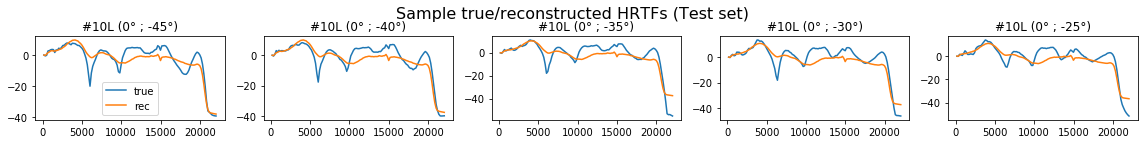

SD (test): 4.911372618917365


## Fold 2/10

Split train/test: 49/6
Train set: (17689, 33)
Test set: (2166, 33)


### Apply PCA on train

Max SD (train): 1.6344542556202908


### Apply PCA on test

Max SD (test): 1.7315549906540535


### Train DNN model

Training dnn_74893991_fold_02 from 0 to 300..
(17689, 65) (17689, 2)


loss: 168.6830, val_loss: 166.7308:  26%|██▌       | 78/300 [00:22<01:02,  3.52it/s]


### Apply PCA/DNN model on train

SD (train): 4.049444421800996


### Apply PCA/DNN model on test

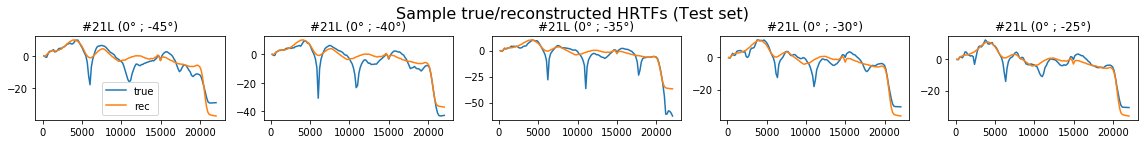

SD (test): 4.415800417517455


## Fold 3/10

Split train/test: 49/6
Train set: (17689, 33)
Test set: (2166, 33)


### Apply PCA on train

Max SD (train): 1.6515343452356552


### Apply PCA on test

Max SD (test): 1.6067548179242244


### Train DNN model

Training dnn_74893991_fold_03 from 0 to 300..
(17689, 65) (17689, 2)


loss: 196.0145, val_loss: 201.3959:  23%|██▎       | 68/300 [00:20<01:09,  3.34it/s]


### Apply PCA/DNN model on train

SD (train): 4.464328368378023


### Apply PCA/DNN model on test

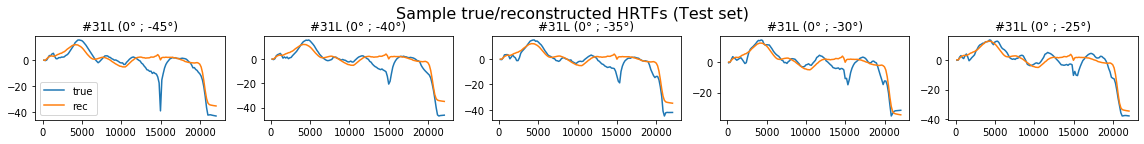

SD (test): 4.9929371294192615


## Fold 4/10

Split train/test: 49/6
Train set: (17689, 33)
Test set: (2166, 33)


### Apply PCA on train

Max SD (train): 1.623064028948169


### Apply PCA on test

Max SD (test): 1.8172516909992178


### Train DNN model

Training dnn_74893991_fold_04 from 0 to 300..
(17689, 65) (17689, 2)


loss: 194.9309, val_loss: 172.0240:  15%|█▌        | 45/300 [00:13<01:18,  3.24it/s]


### Apply PCA/DNN model on train

SD (train): 4.497421414419431


### Apply PCA/DNN model on test

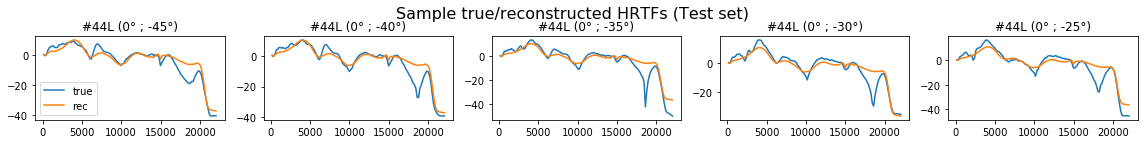

SD (test): 4.550733761516591


## Fold 5/10

Split train/test: 49/6
Train set: (17689, 33)
Test set: (2166, 33)


### Apply PCA on train

Max SD (train): 1.6653610943646622


### Apply PCA on test

Max SD (test): 1.5901162916552252


### Train DNN model

Training dnn_74893991_fold_05 from 0 to 300..
(17689, 65) (17689, 2)


loss: 173.0184, val_loss: 197.2587:  25%|██▍       | 74/300 [00:22<01:07,  3.33it/s]


### Apply PCA/DNN model on train

SD (train): 4.0665890668542275


### Apply PCA/DNN model on test

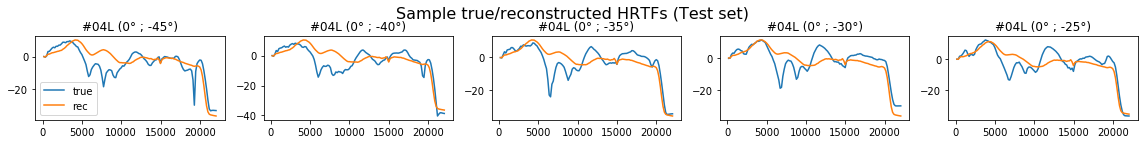

SD (test): 4.662163617472743


## Fold 6/10

Split train/test: 50/5
Train set: (18050, 33)
Test set: (1805, 33)


### Apply PCA on train

Max SD (train): 1.6442292284674611


### Apply PCA on test

Max SD (test): 1.6828737804870584


### Train DNN model

Training dnn_74893991_fold_06 from 0 to 300..
(18050, 65) (18050, 2)


loss: 150.4693, val_loss: 174.2652:  52%|█████▏    | 157/300 [00:45<00:41,  3.48it/s]


### Apply PCA/DNN model on train

SD (train): 3.7125542249929833


### Apply PCA/DNN model on test

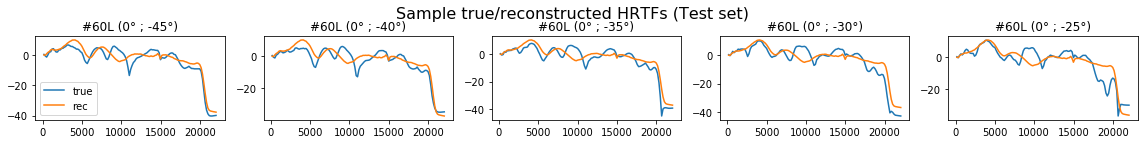

SD (test): 4.548541085793441


## Fold 7/10

Split train/test: 50/5
Train set: (18050, 33)
Test set: (1805, 33)


### Apply PCA on train

Max SD (train): 1.646839146996235


### Apply PCA on test

Max SD (test): 1.6626272368337187


### Train DNN model

Training dnn_74893991_fold_07 from 0 to 300..
(18050, 65) (18050, 2)


loss: 160.4068, val_loss: 194.2023:  39%|███▉      | 118/300 [00:32<00:50,  3.61it/s]


### Apply PCA/DNN model on train

SD (train): 3.866514320529551


### Apply PCA/DNN model on test

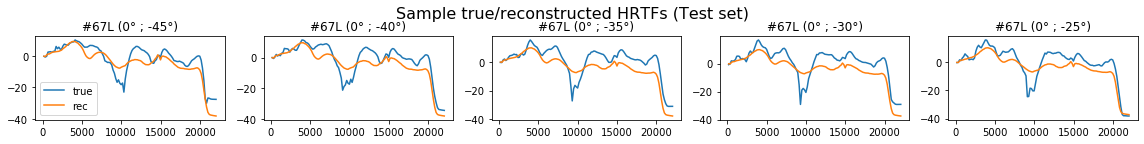

SD (test): 4.690218430028214


## Fold 8/10

Split train/test: 50/5
Train set: (18050, 33)
Test set: (1805, 33)


### Apply PCA on train

Max SD (train): 1.6489177881748325


### Apply PCA on test

Max SD (test): 1.6580968482587675


### Train DNN model

Training dnn_74893991_fold_08 from 0 to 300..
(18050, 65) (18050, 2)


loss: 160.4268, val_loss: 168.0595:  38%|███▊      | 114/300 [00:34<00:56,  3.30it/s]


### Apply PCA/DNN model on train

SD (train): 3.8323672904003745


### Apply PCA/DNN model on test

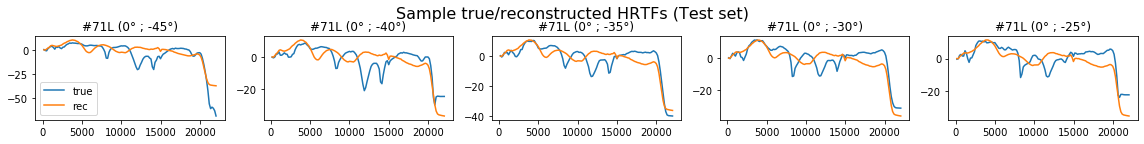

SD (test): 4.588701358514465


## Fold 9/10

Split train/test: 50/5
Train set: (18050, 33)
Test set: (1805, 33)


### Apply PCA on train

Max SD (train): 1.629473478410108


### Apply PCA on test

Max SD (test): 1.8707768231059037


### Train DNN model

Training dnn_74893991_fold_09 from 0 to 300..
(18050, 65) (18050, 2)


loss: 159.7184, val_loss: 210.3126:  39%|███▉      | 117/300 [00:34<00:54,  3.38it/s]


### Apply PCA/DNN model on train

SD (train): 3.9273516381513476


### Apply PCA/DNN model on test

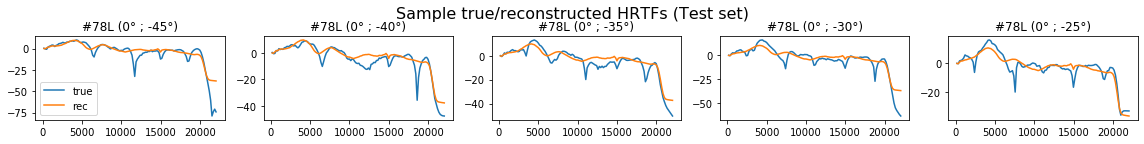

SD (test): 5.102944423197298


## Fold 10/10

Split train/test: 50/5
Train set: (18050, 33)
Test set: (1805, 33)


### Apply PCA on train

Max SD (train): 1.6426698508723627


### Apply PCA on test

Max SD (test): 1.6334767137937778


### Train DNN model

Training dnn_74893991_fold_10 from 0 to 300..
(18050, 65) (18050, 2)


loss: 172.5955, val_loss: 213.3500:  25%|██▌       | 76/300 [00:23<01:10,  3.19it/s]


### Apply PCA/DNN model on train

SD (train): 4.180064826241503


### Apply PCA/DNN model on test

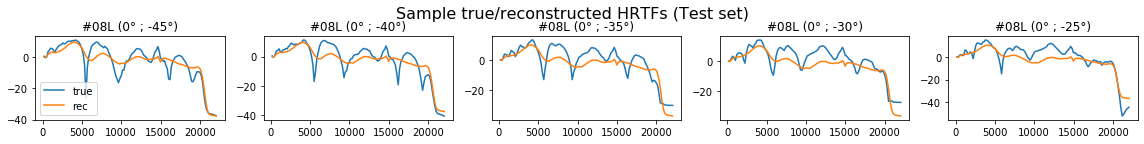

SD (test): 4.7667649442928655


In [76]:
# data structures
fold_results = []

log_id = int(time.time()) % 99999999
kf = KFold(n_splits=n_splits)
for i, indexes in enumerate(kf.split(ids)):
    train_index, test_index = indexes
    display(Markdown(f'## Fold {i+1}/{n_splits}'))
    
    # load data splits
    (hrtf_train, depth_train, anthro_train, meta_train), (hrtf_test, depth_test, anthro_test, meta_test) = split_sets(data, train_index, test_index)
#     if i==0:
#         plot_norm_hrtfs(hrtf_train, meta_train)
    
    pcadnn = PCADNN()
    # train PCA models
    pcadnn.hrtf_pca_train(hrtf_train, n_pc=n_pc)
    pcadnn.depth_pca_train(depth_train, n_pc=40)
    
    # process train data
    display(Markdown('### Apply PCA on train'))
    hrtf_train_pca, hrtf_train_rec = pcadnn.hrtf_pca_compress(hrtf_train)
    sd_train_rec = spectral_distortion(hrtf_train, hrtf_train_rec, freqs, f_range)
#     if i==0:
#         x_train_pca_df = pcadnn.pc_to_df(x_train_pca, y_train)
#         plot_pca_pairs(x_train_pca_df, 'Train')
#         plot_rec_hrtf(x_train, x_train_rec, y_train, 'Train')
#         plot_corr(x_train_pca_df, y_train, 'Train')
    print(f'Max SD (train): {sd_train_rec.mean()}')
        
    # process test data
    display(Markdown('### Apply PCA on test'))
    hrtf_test_pca, hrtf_test_rec = pcadnn.hrtf_pca_compress(hrtf_test)
    sd_test_rec = spectral_distortion(hrtf_test, hrtf_test_rec, freqs, f_range)
#     if i==0:
#         x_test_pca_df = pcadnn.pc_to_df(x_test_pca, y_test)
#         plot_pca_pairs(x_test_pca_df, 'Test')
#         plot_rec_hrtf(x_test, x_test_rec, y_test, 'Test')
#         plot_corr(x_test_pca_df, y_test, 'Test')
    print(f'Max SD (test): {sd_test_rec.mean()}')
    
    # load anthropometric/pca data and train DNN
    display(Markdown('### Train DNN model'))
    data_train = (hrtf_train, depth_train, anthro_train, meta_train)
    data_test  = (hrtf_test, depth_test, anthro_test, meta_test)
    model_name = f'dnn_{log_id}_fold_{i+1:02}'    
    pcadnn.dnn_train(data_train, data_test, filters_layers, batch_size, epochs, model_name)
            
    # process train data
    display(Markdown('### Apply PCA/DNN model on train'))
    inputdata_train = (depth_train, anthro_train, meta_train)
    hrtf_train_pred = pcadnn.model_apply(inputdata_train)
    sd_train_pred = spectral_distortion_minimize(hrtf_train, hrtf_train_pred, freqs, f_range)
#     if i==0:
#         plot_rec_hrtf(hrtf_train, hrtf_train_pred, meta_train, 'Train', nr=1, nc=5)
    print(f'SD (train): {sd_train_pred.mean()}')
    
    # process test data
    display(Markdown('### Apply PCA/DNN model on test'))
    inputdata_test = (depth_test, anthro_test, meta_test)
    hrtf_test_pred = pcadnn.model_apply(inputdata_test)
    sd_test_pred = spectral_distortion_minimize(hrtf_test, hrtf_test_pred, freqs, f_range)
    plot_rec_hrtf(hrtf_test, hrtf_test_pred, meta_test, 'Test', nr=1, nc=5)
    print(f'SD (test): {sd_test_pred.mean()}')

    fold_results.append({
        'sd_max_train': sd_train_rec.mean(),
        'sd_max_test': sd_test_rec.mean(),
        'sd_train': sd_train_pred.mean(),
        'sd_test': sd_test_pred.mean(),
        'fold': i+1
    })
    
    
#     if i > 1:
#         print('FOrCE QUiTTiNG')
#         break
    
results_df = pd.DataFrame(fold_results)

# Results

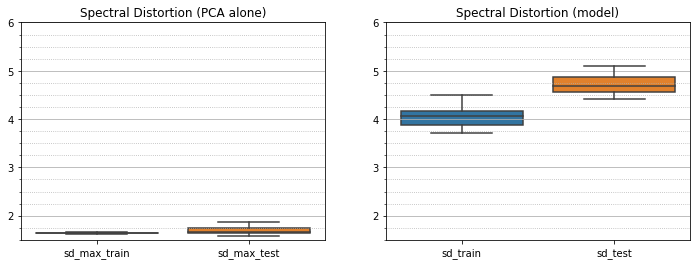

sd_max_train    1.643493
sd_max_test     1.699407
sd_train        4.072281
sd_test         4.723018
fold            5.500000
dtype: float64


In [77]:
plot_results(results_df)

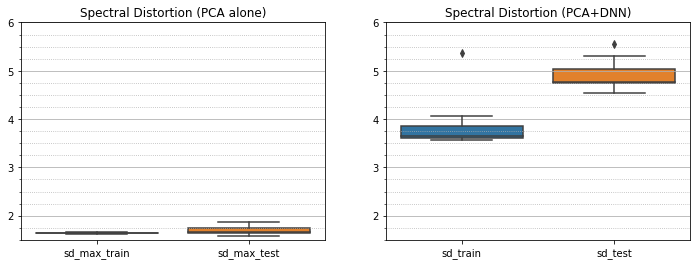

sd_max_train    1.643528
sd_max_test     1.699423
sd_train        3.873630
sd_test         4.912218
fold            5.500000
dtype: float64

In [72]:

results_df = pd.DataFrame(fold_results)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=results_df[['sd_max_train', 'sd_max_test']], ax=ax[0])
ax[0].set_title('Spectral Distortion (PCA alone)')
format_boxwhisker(ax[0])
sns.boxplot(data=results_df[['sd_train', 'sd_test']], ax=ax[1])
ax[1].set_title('Spectral Distortion (PCA+DNN)')
format_boxwhisker(ax[1])
plt.show()

In [644]:
results_df.mean()

sd_max_train    1.662046
sd_max_test     1.695583
sd_train        4.539759
sd_test         4.680540
fold            5.500000
dtype: float64

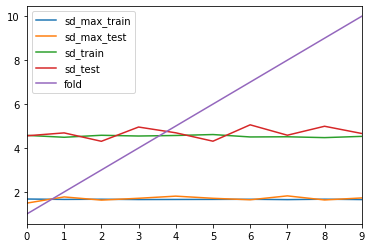

In [645]:
results_df.plot()

In [ ]:
res_train = y_train[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = sd

# spectral distortion on train data (various sub-groupings)
fig, axs = plt.subplots(3,1, figsize=(18,6))
res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
res_train.groupby(['elevation']).mean()['SD'].plot.bar(ax=axs[2])
fig.tight_layout()
print('mean SD (train)= ', res_train['SD'].mean())

In [49]:
np.random.rand(5,3).std(axis=0).round(3)

array([0.292, 0.175, 0.236])